# Topic Modelling

Topic Modelling helps us identify the hidden topics among the customer's review. Knowing these topics enable DisneyLand to identify areas of improvement, allowing DisneyLand to improve their customer's experience at DisneyLand.

## Import libraries and download the packages

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import gensim
from gensim import corpora

## Read the dataset

In [2]:
df = pd.read_csv("topic_modelling_reviews.csv")

In [3]:
df.head()

,reviews
0,"['everyone', 'said', 'days', 'christmas', 'bus..."
1,"['went', 'great', 'much', 'better', 'kids', 'g..."
2,"['good', 'amusement', 'crowded', 'looking', 'f..."
3,"['love', 'love', 'love', 'place', 'came', 'sin..."
4,"['somewhere', 'finances', 'afford', 'freedom',..."


In [4]:
# Converting the string of list of tokens to normal lists.
import ast
df.reviews = df.reviews.apply(ast.literal_eval)

In [5]:
print("Number of texts in the dataframe:",df.shape[0])

Number of texts in the dataframe: 10902


## Data Preparation

In [8]:
# Lemmatize the words and keep lemmatized words with lengths above 2.
lemma = WordNetLemmatizer()
for index in range(df.shape[0]):
    normalized = []
    for words in df.reviews[index]:
        normalized_word = lemma.lemmatize(words)
        if len(normalized_word)>2:
            normalized.append(normalized_word)
    df.reviews[index] = normalized

In [9]:
# Tokenize the words to generate frequency of words.
from nltk.tokenize import word_tokenize

# Get the tokenized words
tokenized_word_list = [word for word_list in df.reviews for word in word_list]

# Generate word frequencies
all_words_frequency = nltk.FreqDist(tokenized_word_list)

In [10]:
print("Total number of terms in the document:",len(all_words_frequency))

Total number of terms in the document: 14712


In [11]:
print("Top 100 common words:",all_words_frequency.most_common(100))

Top 100 common words: [('ride', 12012), ('time', 9191), ('day', 7557), ('line', 6051), ('place', 5175), ('one', 4554), ('people', 3875), ('pas', 3866), ('wait', 3448), ('like', 3415), ('year', 3355), ('kid', 3198), ('experience', 2995), ('food', 2989), ('hour', 2971), ('great', 2969), ('even', 2966), ('fast', 2730), ('ticket', 2696), ('family', 2599), ('long', 2560), ('much', 2462), ('make', 2397), ('really', 2371), ('fun', 2364), ('went', 2325), ('many', 2259), ('see', 2243), ('visit', 2232), ('first', 2155), ('money', 2106), ('going', 2045), ('way', 2031), ('love', 2025), ('good', 1998), ('also', 1974), ('got', 1974), ('lot', 1967), ('minute', 1963), ('take', 1900), ('world', 1858), ('still', 1784), ('every', 1740), ('always', 1736), ('show', 1733), ('could', 1716), ('thing', 1688), ('never', 1678), ('around', 1645), ('come', 1610), ('price', 1587), ('well', 1579), ('california', 1557), ('park', 1552), ('crowd', 1525), ('worth', 1512), ('star', 1504), ('pass', 1455), ('want', 1453), 

These words are common and may make it difficult for the model to differentiate the terms to create unqiue topics. Therefore, I will remove these terms for the model to be able to separate the topics better.

In [12]:
# Extract the top 100 common words for removal
common_words = [word for (word,value) in all_words_frequency.most_common(100)]

In [13]:
print(common_words)

['ride', 'time', 'day', 'line', 'place', 'one', 'people', 'pas', 'wait', 'like', 'year', 'kid', 'experience', 'food', 'hour', 'great', 'even', 'fast', 'ticket', 'family', 'long', 'much', 'make', 'really', 'fun', 'went', 'many', 'see', 'visit', 'first', 'money', 'going', 'way', 'love', 'good', 'also', 'got', 'lot', 'minute', 'take', 'world', 'still', 'every', 'always', 'show', 'could', 'thing', 'never', 'around', 'come', 'price', 'well', 'california', 'park', 'crowd', 'worth', 'star', 'pass', 'want', 'trip', 'child', 'parade', 'staff', 'member', 'crowded', 'earth', 'everything', 'character', 'better', 'two', 'mountain', 'old', 'need', 'say', 'know', 'amazing', 'best', 'happiest', 'adventure', 'new', 'expensive', 'little', 'magic', 'waiting', 'attraction', 'cast', 'magical', 'parking', 'service', 'firework', 'since', 'sure', 'think', 'last', 'employee', 'made', 'enjoy', 'able', 'pay', 'said']


In [14]:
# Iterate through the dataframe and remove the top common words.
for index in range(df.shape[0]):
    uncommon = []
    for words in df.reviews[index]:
        if words not in common_words:
            uncommon.append(words)
    df.reviews[index] = uncommon

In [15]:
# Creating the term matrix
dictionary = corpora.Dictionary(df.reviews) # unique terms

# Creating term count
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df.reviews]

In [18]:
# To ensure sufficient but not too much topics, I will test topics in range 4 to 8 with intervals of 1.
topic_num_list = list(np.arange(4,9,1))

topic_num_list

[4, 5, 6, 7, 8]

## Modelling 

In [19]:
from pprint import pprint
from gensim.models import CoherenceModel

no_topic_tested = []
perplexity_scores = []
coherence_score = []
Lda = gensim.models.LdaMulticore
for number_of_topics in topic_num_list:
    print("Testing with",number_of_topics,"topics.")
#     print("Running the LDA Model")
    ldamodel = Lda(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, passes=10, random_state=42)
    # The default number of passes is 1.
    # A higher pass also means the model learns more from the data. 
    # However, the model will become computationally expensive and time consuming.
    # To reduce the computational time while ensuring sufficient iterations are made, I will use only 10 passes.

    # random_state is passed to ensure reproducable results for training and tuning.

    perplexity_score = ldamodel.log_perplexity(doc_term_matrix)

    # Coherence c_v is generally the most interpretable, therefore I set the coherence to c_v.
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=df.reviews, dictionary=dictionary, coherence='c_v')
    no_topic_tested.append(number_of_topics)
    perplexity_scores.append(float(perplexity_score))
    coherence_score.append(coherence_model_lda.get_coherence())
    print()

model_result = pd.DataFrame({'Number of Topics':no_topic_tested, 'Perplexity':perplexity_scores, 'Coherence':coherence_score})
model_result.sort_values(by='Coherence', ascending=False)

Testing with 4 topics.

Testing with 5 topics.

Testing with 6 topics.

Testing with 7 topics.

Testing with 8 topics.



,Number of Topics,Perplexity,Coherence
1,5,-8.039696,0.397245
4,8,-8.111040,0.376143
2,6,-8.064139,0.375133
0,4,-8.011132,0.370975
3,7,-8.091944,0.369993


<AxesSubplot:xlabel='Number of Topics'>

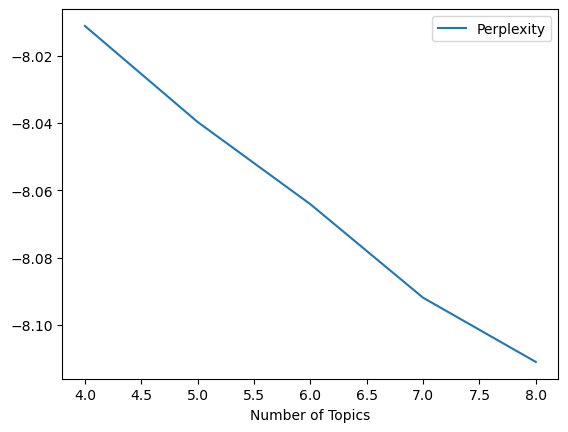

In [20]:
model_result.plot.line(y='Perplexity', x='Number of Topics')

- Perplexity is calculated by taking the log likelihood of unseen text documents given the topics defined by a topic model.
- A good model will have a high likelihood and resultantly low perplexity.
- But sometimes these metrics are not correlated with human interpretability of the model, which can be impractical in a business setting.

From 4 to 8 topics, the perplexity score decreased increasingly.

Although a lower perplexity score is better, a lower perplexity score is achieved as there will be less unique topics in each document. Since I want to ensure that the topics are still unqiue, I will look at the Coherence score instead.

<AxesSubplot:xlabel='Number of Topics'>

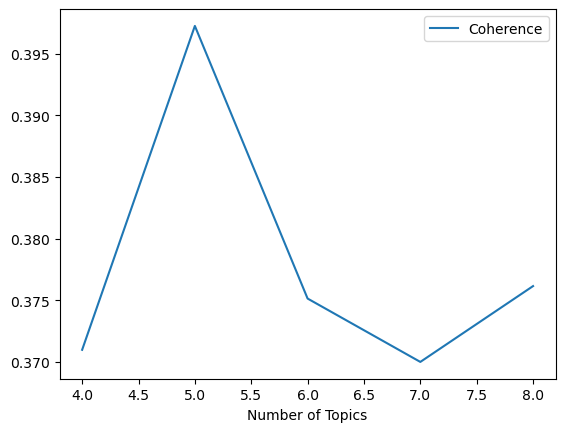

In [21]:
# Look for the highest coherence value
model_result.plot.line(y='Coherence', x='Number of Topics')

Topic coherence looks at a set of words in generated topics and rates the interpretability of the topics. The higher the value, the better the model, and the more interpretable the topics are.

Since 5 topics has the highest coherence score of 0.3972, I will check out its intertopic distance

In [22]:
ldamodel = Lda(doc_term_matrix, num_topics = int(model_result['Number of Topics'][model_result['Coherence'] == model_result['Coherence'].max()]), id2word = dictionary, passes=10, random_state=42)

In [23]:
# Enter codes here
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

# visualize the topics and keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
vis

C:\Users\fangg\anaconda3_new\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\fangg\anaconda3_new\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.072219  0.006256       1        1  23.676829
1     -0.082931 -0.010069       2        1  22.914850
4     -0.028796  0.013425       3        1  20.684640
2      0.027709 -0.049452       4        1  16.696444
3      0.011799  0.039839       5        1  16.027238, topic_info=         Term        Freq        Total Category  logprob  loglift
119     spend  735.000000   735.000000  Default  30.0000  30.0000
70     pirate  612.000000   612.000000  Default  29.0000  29.0000
443   indiana  577.000000   577.000000  Default  28.0000  28.0000
452     jones  609.000000   609.000000  Default  27.0000  27.0000
2818     lane  282.000000   282.000000  Default  26.0000  26.0000
...       ...         ...          ...      ...      ...      ...
392      find  148.941548   776.525275   Topic5  -5.9747   0.1796
280   another  159.597436  1006.923455   Topic5  -5.9056  -0.0111
751       let  145.017669   852.950575   Topic5  -6.0014   0.0590
167      ever  143.403861   976.150858   Topic5  -6.0126  -0.0871
255     small  141.930674   905.713711   Topic5  -6.0229  -0.0225

[459 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
6138      3  0.775249           abc
5946      2  0.851503      accessed
6164      1  0.879107  accidentally
6654      1  0.236851           ada
6654      2  0.039475           ada
...     ...       ...           ...
129       2  0.172230           yes
129       3  0.316746           yes
129       4  0.067308           yes
129       5  0.053451           yes
5057      1  0.796045       zippity

[1353 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

With 100 most common words removed and lemmatized words left in the dataframe, the topics are now much more easy to interpret and the intertopic distance is now larger. This is a good progress as compared to the previous intertopic distance map, where all topics have roughly the same terms.

In [24]:
pprint(ldamodel.print_topics(num_topics=5, num_words=20))

[(0,
  '0.007*"told" + 0.005*"customer" + 0.004*"rude" + 0.004*"another" + '
  '0.004*"ever" + 0.004*"used" + 0.004*"let" + 0.004*"guest" + 0.004*"annual" '
  '+ 0.004*"asked" + 0.003*"paid" + 0.003*"use" + 0.003*"disappointed" + '
  '0.003*"spent" + 0.003*"phone" + 0.003*"help" + 0.003*"nothing" + '
  '0.003*"worst" + 0.003*"person" + 0.003*"daughter"'),
 (1,
  '0.007*"early" + 0.005*"pirate" + 0.005*"jones" + 0.005*"indiana" + '
  '0.005*"space" + 0.005*"fastpass" + 0.005*"favorite" + 0.005*"closed" + '
  '0.005*"app" + 0.004*"water" + 0.004*"small" + 0.004*"haunted" + '
  '0.004*"awesome" + 0.004*"area" + 0.004*"recommend" + 0.004*"bring" + '
  '0.004*"use" + 0.004*"big" + 0.003*"mansion" + 0.003*"plan"'),
 (2,
  '0.006*"spend" + 0.004*"least" + 0.004*"cost" + 0.003*"lane" + 0.003*"let" + '
  '0.003*"ever" + 0.003*"guest" + 0.003*"bad" + 0.003*"something" + '
  '0.003*"getting" + 0.003*"keep" + 0.003*"land" + 0.003*"lightning" + '
  '0.003*"care" + 0.003*"customer" + 0.003*"everyone

Looking at the individual topic and their terms, the topics are not very clear. These are the topics I assume it to be:
    
* Topic 0: Rude Service
* Topic 1: Themes
* Topic 2: Costs
* Topic 3: War
* Topic 4: Customer Recommendation

From these identified topics, DisneyLand could consider reviewing their staff's attitude and approach to managing their customers. By identifying and correcting the way staffs manage their customers, DisneyLand could potentially improve their customer's experience and satisfaction level, leading to higher chances of custome rrecommendations.